#### **Voronoi Diagram Generation within Circular Bounds**

This code generates and filters Voronoi diagrams from clustered points within a circular boundary.

### **Key Steps:**
1. **Generates clustered points** using `create_clustered_points()` function with:
   - 300 total points distributed across 2 clusters
   - Cluster centers restricted to (0.35, 0.75) range
   - Moderate cluster spread (0.3)

2. **Creates Voronoi diagram** from the clustered points using SciPy's `Voronoi` class

3. **Filters polygons** to keep only those completely within a circular boundary:
   - Center at (0.5, 0.5) with radius 0.6
   - Uses `is_polygon_within_circle()` to validate containment

4. **Calculates polygon areas** using the shoelace formula

5. **Exports filtered polygons** as GeoJSON format (`bounded_polygons.geojson`) containing:
   - Polygon coordinates
   - Vertex counts
   - Calculated areas

6. **Visualizes results** showing only the within-bound polygons with semi-transparent fill

### **Outputs:**
- Console log with polygon count statistics
- GeoJSON file with filtered polygons
- Matplotlib visualization of the bounded Voronoi diagram

874

Found 219 polygons completely within bounds
1
3
4
0
1
3
1
3
2
1
1
1
1
1
1
2
2
3
1
2
1
4
3
4
1
0
1
3
1
1
1
0
2
3
1
2
2
1
0
0
0
3
1
2
2
4
0
4
0
0
1
1
2
1
1
2
3
1
1
0
3
2
1
2
4
3
2
3
1
0
1
1
1
2
3
2
0
1
1
0
0
1
1
0
1
3
1
1
1
0
2
1
2
1
4
1
0
1
1
2
1
1
1
0
0
1
3
1
2
2
3
3
3
4
0
2
1
1
1
3
4
4
3
3
3
1
2
1
1
2
4
1
1
0
4
1
3
1
1
2
1
4
4
3
3
1
0
2
0
0
1
1
0
1
1
0
2
1
4
1
3
1
0
1
3
1
1
1
1
0
1
0
1
1
0
1
0
1
1
0
0
1
3
3
2
3
1
2
1
0
1
1
1
1
1
1
0
4
0
0
2
3
3
0
1
2
2
4
3
1
1
3
1
2
1
1
1
1
3

Saved 219 within-bounds polygons to bounded_polygons.geojson


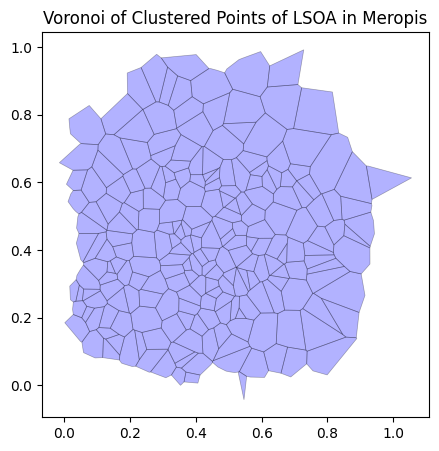

In [12]:
import numpy as np
from scipy.spatial import Voronoi
from scipy.spatial.distance import euclidean
import json
import random
import matplotlib.pyplot as plt



NUMBER_OF_POINTS = 300



def create_clustered_points(n_points=1000, n_clusters=5, cluster_spread=0.1,center_range=(0.15, 0.95)):
    """Cluster centers restricted to specific range"""
    low, high = center_range
    
    # Cluster centers within restricted range
    cluster_centers = np.random.rand(n_clusters, 2) * (high - low) + low# 2 is the dimension
    
    # 2. Assign points to clusters (random distribution)
    cluster_assignments = np.random.randint(0, n_clusters, n_points)
    
    # 3. Create points around their cluster centers
    points = []
    for i in range(n_points):
        cluster_idx = cluster_assignments[i]
        center = cluster_centers[cluster_idx]
        
        # Add random offset (smaller = tighter cluster)
        offset = np.random.randn(2) * cluster_spread
        point = center + offset
        
        # Keep within 0-1 bounds
        point = np.clip(point, 0, 1)
        points.append(point)
    
    return np.array(points),cluster_centers


def is_polygon_within_circle(polygon, center, radius):
    """Return True if ALL polygon vertices are within circle, False otherwise"""
    center_x, center_y = center
    
    for x, y in polygon:
        # Calculate distance from center
        distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        if distance > radius:
            return False
    
    return True

rnd_seed = random.randint(1,1000)
rnd_seed = 874
random.seed(rnd_seed)
print(rnd_seed)


# 2. Define circular bounds
midpoint = np.array([0.5, 0.5])  # Center of the 0-1 range
radius = 0.6  # Circle radius


# 1. Create points and Voronoi
points,cluster_centers = create_clustered_points(NUMBER_OF_POINTS, 2,0.3,(0.15, 0.85))
vor = Voronoi(points)




# 4. Get only polygons that are completely within bounds
polygons = []
polygon_areas = []  # Store areas for plotting
original_indices = []
area_types = []

for i in range(NUMBER_OF_POINTS):
    region_idx = vor.point_region[i]
    region = vor.regions[region_idx]
    
    if region and -1 not in region:
        polygon = vor.vertices[region]
        
        # Check if polygon is within bounds
        if is_polygon_within_circle(polygon, midpoint, radius):
            x = polygon[:, 0]
            y = polygon[:, 1]
            area = 0.5 * np.abs(
                np.dot(x, np.roll(y, 1)) - 
                np.dot(y, np.roll(x, 1))
            )
            polygon_areas.append(area)
            polygons.append(polygon)
            original_indices.append(i);
            
           
print(f"\nFound {len(polygons)} polygons completely within bounds")

average_area = np.average(polygon_areas)

admin_areas = cluster_centers.copy()
new_points = np.random.rand(3, 2)             # shape: (3, 2)
admin_areas = np.vstack((admin_areas, new_points))

# 6. Convert good polygons to GeoJSON
if polygons:
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    new_id = 1
    for poly_index, polygon in enumerate(polygons):
        original_index = original_indices[poly_index]
        area = polygon_areas[poly_index]
        urban = False
        area_type = ""

        closest_adminarea_idx = 0
        distance = 10
        for i in range(len(admin_areas)):
            d = euclidean(admin_areas[i],points[original_index])
            if d< distance:
                closest_adminarea_idx = i
                distance = d
            
        for center in cluster_centers:
            if (euclidean(center,points[original_index])<0.1):
                urban = True
                area_type = "city"
        if (area_type==""):
            if area< (average_area*0.5):
                area_type = "market_town"
                urban = True
            else:
                area_type = "agricultural"
        # Close the polygon
        closed_coords = np.vstack([polygon, polygon[0]]).tolist()
        
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [closed_coords]
            },
            "properties": {
                "id": int(new_id),
                "admin_area": int(closest_adminarea_idx),
                "vertices": len(polygon),
                "area": float(area),
                "urban":urban,
                "type": area_type,
                "population": int(random.gauss(500, 20)) 
            }
        }
        geojson["features"].append(feature)
        new_id+=1
    
    # Save
    with open('bounded_polygons.geojson', 'w') as f:
        json.dump(geojson, f, indent=2)
    
    print(f"\nSaved {len(geojson['features'])} within-bounds polygons to bounded_polygons.geojson")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot only the selected polygons (within circle)
for polygon in polygons:
    ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.3, edgecolor='black', facecolor="blue",linewidth=0.5)



ax.set_title("Voronoi of Clustered Points of LSOA in Meropis")
plt.show()

In [10]:
admin_areas

array([[0.47097467, 0.54800607],
       [0.32893035, 0.16179065],
       [0.61961422, 0.96605626],
       [0.25246622, 0.99178177],
       [0.96316122, 0.52048241]])

In [11]:
len(admin_areas)

5